# NLP with Bert for SQL injections detecting

**Importing the libraries**

In [ ]:
!pip install ktrain 
!pip install chardet
import numpy as np
import ktrain
from ktrain import text
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

**Reading and displaying the dataset**

In [5]:
# Detect the encoding of the CSV file
with open('sqliv2.csv', 'rb') as f:
    result = chardet.detect(f.read())

# Read the CSV file into a pandas dataframe, using the detected encoding
df = pd.read_csv('sqliv2.csv', sep=',',  encoding=result['encoding']).sample(n=250)

# Display the first rows of the dataframe
print(df.head(10))

                                                Sentence  Label
13822  1'  )  )   and 3824 = benchmark ( 5000000,md5 ...      1
32850                                              dacio      0
30256                                           coladiza      0
29464                                    tarrats steiert      0
18612                                              04271      0
31237                                    shail@arrsys.mz      0
29271                                              suany      0
22788                                              1erso      0
23088                                         rost jorge      0
2307    &quot; However , merely chronicle Geisingen ,...      0


In [6]:
df.shape

(250, 2)

In [7]:
print("----------------------------------------------------")
df.info()
print("----------------------------------------------------")

----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 13822 to 5760
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  250 non-null    object
 1   Label     250 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.9+ KB
----------------------------------------------------


In [8]:
df['Label'].describe()


count    250.000000
mean       0.336000
std        0.473286
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Label, dtype: float64

**Process NaN values**

In [9]:
df['Label'].isna().sum() # Count NaN label values.


0

**the target label**

In [10]:
# Get unique values existing in the label column.

unique_label = pd.unique(df['Label'])

print(unique_label)

[1 0]


In [11]:
df[df['Label'] == 1].count() # Count how much label are 1.


Sentence    84
Label       84
dtype: int64

In [12]:
df[df['Label'] == 0].count() # Count how much label are 0.


Sentence    166
Label       166
dtype: int64

**Distribution of the label**

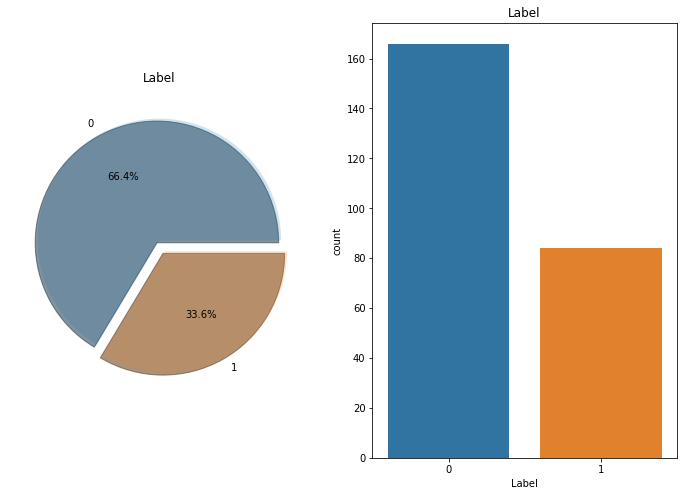

In [14]:
f,ax=plt.subplots(1,2,figsize=(12,8))
df['Label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True, wedgeprops={'alpha':0.2})

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot('Label', data=df, ax=ax[1])
ax[1].set_title('Label')
plt.show()

**Creating the training and test sets**

In [15]:
sentences = df['Sentence'].tolist()
labels = df['Label'].tolist()

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

(x_train, y_train), (x_test, y_test), preproc = text.texts_from_array(sentences_train, labels_train, 
                                                                       preprocess_mode='bert',
                                                                       maxlen=100,
                                                                      class_names=list(set(labels_train))
                                                                      )

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


# Building the BERT model

In [16]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 100


/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


# Training the BERT model

In [17]:
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6)

In [18]:
learner.fit_onecycle(lr=2e-5, epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
30/30 [==============================] - 33s 343ms/step - loss: 0.3069 - accuracy: 0.9111 - val_loss: 0.0914 - val_accuracy: 1.0000
Epoch 2/3
30/30 [==============================] - 5s 161ms/step - loss: 0.0628 - accuracy: 0.9889 - val_loss: 0.0180 - val_accuracy: 1.0000
Epoch 3/3
30/30 [==============================] - 5s 162ms/step - loss: 0.0298 - accuracy: 0.9944 - val_loss: 0.0131 - val_accuracy: 1.0000


In [19]:
learner.validate(class_names=preproc.get_classes())


1/1 [==============================] - 6s 6s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



array([[12,  0],
       [ 0,  8]])

In [30]:
predictor = ktrain.get_predictor(learner.model, preproc)

# make a prediction on a single input text
input_text = "SELECT * FROM users WHERE username='admin' OR 1=1;"
prediction = predictor.predict(input_text)
print(prediction)

1/1 [==============================] - 0s 181ms/step
1
